In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Load and preprocess MNIST dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [6]:
# Generator model
def build_generator():
    noise_dim = 100
    label_dim = 10  # One-hot encoded labels
    
    noise_input = layers.Input(shape=(noise_dim,))
    label_input = layers.Input(shape=(label_dim,))
    
    combined_input = layers.Concatenate()([noise_input, label_input])
    
    model = tf.keras.Sequential([
        layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(noise_dim + label_dim,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    
    generated_image = model(combined_input)
    return tf.keras.Model([noise_input, label_input], generated_image)


In [7]:
# Discriminator model
def build_discriminator():
    image_input = layers.Input(shape=(28, 28, 1))
    label_input = layers.Input(shape=(10,))
    
    label_embedding = layers.Dense(28 * 28)(label_input)
    label_embedding = layers.Reshape((28, 28, 1))(label_embedding)
    
    combined_input = layers.Concatenate()([image_input, label_embedding])
    
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    
    output = model(combined_input)
    return tf.keras.Model([image_input, label_input], output)


In [8]:
# Loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Training loop
EPOCHS = 69
noise_dim = 100
num_examples_to_generate = 16

@tf.function
def train_step(images, labels):
    batch_size = tf.shape(labels)[0]  # Ensure dynamic batch size compatibility
    noise = tf.random.normal([batch_size, noise_dim])
    labels_one_hot = tf.one_hot(labels, depth=10)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels_one_hot], training=True)

        real_output = discriminator([images, labels_one_hot], training=True)
        fake_output = discriminator([generated_images, labels_one_hot], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



In [10]:

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch, label_batch in dataset:
            train_step(image_batch, label_batch)

        print(f'Epoch {epoch + 1} completed')

def generate_and_save_images(model, epoch, test_input, test_labels):
    test_labels_one_hot = tf.one_hot(test_labels, depth=10)
    predictions = model([test_input, test_labels_one_hot], training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.title(f'Label: {test_labels[i]}')
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()


2024-12-01 20:17:39.564437: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_5_1/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed
Epoch 10 completed
Epoch 11 completed
Epoch 12 completed
Epoch 13 completed
Epoch 14 completed
Epoch 15 completed
Epoch 16 completed
Epoch 17 completed
Epoch 18 completed
Epoch 19 completed
Epoch 20 completed
Epoch 21 completed
Epoch 22 completed
Epoch 23 completed
Epoch 24 completed
Epoch 25 completed
Epoch 26 completed
Epoch 27 completed
Epoch 28 completed
Epoch 29 completed
Epoch 30 completed
Epoch 31 completed
Epoch 32 completed
Epoch 33 completed
Epoch 34 completed
Epoch 35 completed
Epoch 36 completed
Epoch 37 completed
Epoch 38 completed
Epoch 39 completed
Epoch 40 completed
Epoch 41 completed
Epoch 42 completed
Epoch 43 completed
Epoch 44 completed
Epoch 45 completed
Epoch 46 completed
Epoch 47 completed
Epoch 48 completed
Epoch 49 completed
Epoch 50 completed
Epoch 51 completed
Epoch 52 completed
Epoch 53 completed
Ep

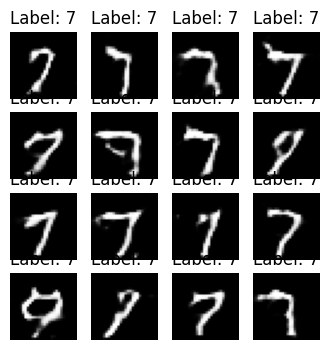

In [11]:

# Train the cGAN
seed = tf.random.normal([num_examples_to_generate, noise_dim])
test_labels = np.random.randint(0, 10, num_examples_to_generate)

train(train_dataset, EPOCHS)

# Generate images for a specific digit
digit_to_generate = 7
test_noise = tf.random.normal([num_examples_to_generate, noise_dim])
test_digit_labels = [digit_to_generate] * num_examples_to_generate
generate_and_save_images(generator, EPOCHS, test_noise, test_digit_labels)
